# Working with Real-World Spectrogram Data

In [1]:
# Perform some preliminary Julia setup
# This may take some time the very first time it runs
using Pkg
Pkg.activate(@__DIR__)
Pkg.instantiate()

using Plots
using HDF5
default(legend=false)

  Activating project at `~/JuliaDeDopplerNotebooks`


## Getting real-world data

We will work with some real-world data recorded by the Breakthrough Listen team
using the Green Bank Telescope.  The file we will use comes from an observation
of the Voyager 1 space probe which was launched in 1977 and has now passed
beyond the heliopause (i.e. the edge of the solar system).  This observation was
originally used for engineering purposes, but now the data from this
obsservation are used primarily for educational/tutorial purposes.

We will use Julia's `download` function to download the file from the public
Breakthrough Listen data archive to a local temporary file and then open that
file using Julia's HDF5 package.  The file uses an HDF5 compression plug-in
known as "bitshuffle" to compress the data.  Installation of the bitshuffle
plug-in for use with Julia's HDF5 package is a bit complicated as of the time
this notebook was originally written, but hopefully by the time you read this it
will be more streamlined.  If not, please consult your local Julia guru for
help.

In [2]:
voyager_url = "http://blpd14.ssl.berkeley.edu/voyager_2020/single_coarse_channel/single_coarse_guppi_59046_80036_DIAG_VOYAGER-1_0011.rawspec.0000.h5"
h5 = h5open(download(voyager_url))

🗂️ HDF5.File: (read-only) /tmp/jl_uCxs4x
├─ 🏷️ CLASS
├─ 🏷️ VERSION
├─ 🔢 data
│  ├─ 🏷️ DIMENSION_LABELS
│  ├─ 🏷️ az_start
│  ├─ 🏷️ data_type
│  ├─ 🏷️ fch1
│  ├─ 🏷️ foff
│  ├─ 🏷️ machine_id
│  ├─ 🏷️ nbits
│  ├─ 🏷️ nchans
│  ├─ 🏷️ nifs
│  ├─ 🏷️ source_name
│  ├─ 🏷️ src_dej
│  ├─ 🏷️ src_raj
│  ├─ 🏷️ telescope_id
│  ├─ 🏷️ tsamp
│  ├─ 🏷️ tstart
│  └─ 🏷️ za_start
└─ 🔢 mask
   └─ 🏷️ DIMENSION_LABELS

As the tree structure shows, the HDF5 file contains HDF5 datasets named `data`
and `mask`.  We will only be using the `data` dataset in this notebook.  The
`data` dataset has several attributes associated with it that describe various
aspects of the data and/or observastaion.  The time and frequency axes of the
spectrogram can be derived from some of these attributes:

- Frequency axis
  - `fch1` - Frequency of first channel
  - `foff` - Frequency step between channels ($\delta_f$)
  - `nchans` - Number of frequency channels ($N_f$)
- Time axis
  - `tstart` - Modified Julian Date (MJD) of the first time sample
  - `tsamp` - Time step between time samples ($\delta_t$)

The dimensionality of the `data` dataset provides additional information not
available in attributes, such as the number of time samples ($N_t$) in the
spectrogram.  Here is the size of the `data` dataset in this file:

In [3]:
size(h5["data"])

(1048576, 1, 16)

As this shows, we can access the datasets by using string indexes into the
`HDF5.File` object stored in the variable named `h5`.  `h5["data"]` returns an
`HDF5.Dataset` object.  This object does not contain the data itself, but it
does contain metadata about the dataset, such as the size of the underlying
data, which we can get by passing the `HDF5.Dataset` object to the `size`
function.

The data in Breakthrough Listen HDF5 files follows a convention
sometimes referred to as *FBH5* because it is modeled after the data array
dimensioning and metadata conventions of an older file format known as
*Filterbank*.  FHB5 is short for "FilterBank Hdf5".

The dimensions of the `data` dataset are: `(nchans, nifs, ntimes)`, where
`nchans` and `nifs` are available as HDF5 attributes of the `data` dataset.  For
total power datasets like the one we are using, `nifs` will be is 1, but for
polarimetric *full Stokes* datasets `nifs` will be 4.  This file has 1048576
frequency channels and 16 time samples and has only total power (i.e. no
polization specific data).

---

Note:

Julia stores multidimensional array data in *column major* order, similar to
Fortran and Matlab.  The indexes into a multidimensional array are given with
the fastest changing index first and the slowest changing index last.  This
ordering of data and indexes can be different from other languages such as C or
Python.  People can (and do) argue about which way is best, but the important
thing is that you understand the underlying ordering of the data and how to
index into them, regardless of which tool you choose to use.

---

## Reading data

Although the `HDF5.Dataset` object does not contain any actual data, it can be
indexed like an `Array` to access the data using HDF5's so called *hyperslab*
indexing.  This supports most of the ways that Julia can index into `Array`s,
but non-regular indexing (e.g. indexing by an array of index values) is not
supported.

Instead of reading in 16 time samples and all 1+ million freqeuncy channels of
this file, we will only read in 16 time samples for a small subset of frequency
channels for demonstration purposes.  These channels were chosen because they
include the main carrier of the transmission from Voyager 1.

If you get an error reading the `data` set, please see the comments above about
the bitshuffle plug-in for HDF5.

In [4]:
freq_range = range(659935, length=150)
spectrogram = h5["data"][freq_range,1,:]
size(spectrogram)

(150, 16)

You will notice that we indexed into `h5["data"]` using a 3 dimensional index,
`[freq_range,1,:]`, but by passing a scalar (i.e. a single value) for the second
dimension that dimension disappeared and the returned `Array` is 2 dimensional.
If we had wanted to preserve the *singleton dimension*, we could have passed a
single-valued range `1:1` instead of a scalar.

## Plotting data

Now that we have a small 2 dimension patch of data in the `spectrogram`
variable, we can take a look at it using the `heatmap` function.

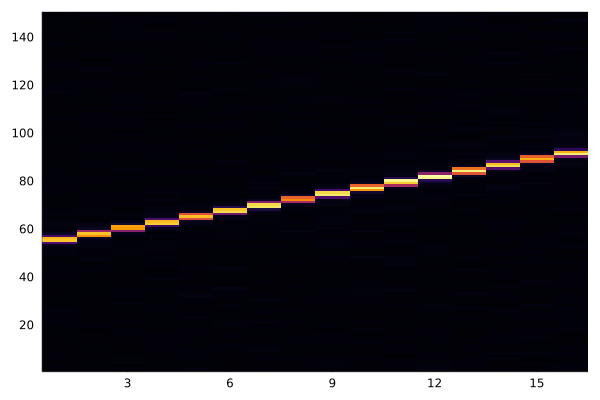

In [5]:
heatmap(spectrogram)

The first thing to point out about the above plot is that the 150 point
frequency axis is the vertical axis and the 16 point time axis is the horizontal
axis.  This is the way that the heapmap function orients Array data.  The
fastest changing index, frequency in this case, is treated as columns so that
dimension is plotted vertically and the second dimension is plotted
horizontally.

This orientation happens to be commonly used in radio transient
analysis, but because SETI searchs often deal with more frequency channels than
time samples, we will prefer to have our plots with frequency on the horizontal
and time on the vertical.  This can be accomplished by transposing the input
array using the `'` operator.

Another thing to point out is that `heatmap` defaults to having the vertical
axis increasing in the upward direction, but in SETI waterfall plots it is more
common to have the vertical axis increasing in a downward direction, which we
can do by passing `yflip=true` to the `heatmap` function.

We can also add a title and label the axes, which makes the plot much more
meaningful to the viewer.

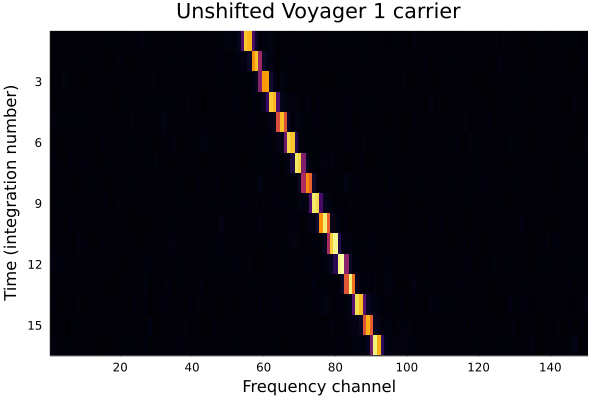

In [6]:
heatmap(spectrogram',
    title="Unshifted Voyager 1 carrier",
    xlabel="Frequency channel",
    ylabel="Time (integration number)",
    yflip=true
)

## Shifting data

We are now ready to write some functions that shift the data in frequency by a
given amount.  For this notebook we will be working with normalized units for
frequency and time (i.e. channel numbers and integration numbers) to keep things
a bit simpler.  These can be related to physical units such as Hz and seconds
through the values $\delta_f$ and $\delta_t$ which are available in the
attributes `foff` and `tsamp`, resp., of the `data` dataset.

We will start off with a simple integer shift that uses Julia `circshift!`
function to shift each column by an integer number of samples, but computed and
rounded from a floating point drift rate.  Remember, Julia's column major
ordering means that frequency appears in the first dimension which is treated as
columns.

In [7]:
function intshift(din, rate)
    dout = similar(din)
    for (i, (cin, cout)) in enumerate(zip(eachcol(din), eachcol(dout)))
        n = round(rate*(i-1))
        circshift!(cout, cin, n)
    end
    return dout
end

intshift (generic function with 1 method)

Let's see what we get with drift rate of -2.37:

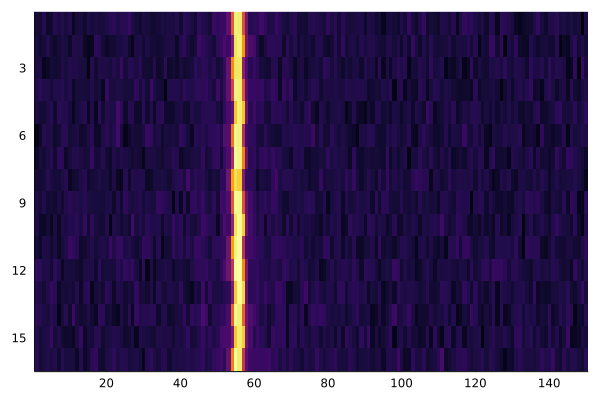

In [8]:
intshift_m237 = intshift(spectrogram, -2.37)
heatmap(log10.(intshift_m237'), yflip=true)

Notice that we are not plotting the data logarithmically using the `log10`
function.  This is a common technique when the dynamic range is very large as it
is with this spectrogram.

We can also sum in the time dimension (i.e. second dimension) and plot the
integrated power spectrum.  Let's do that for both the original and the
`intshift`ed spectrograms:

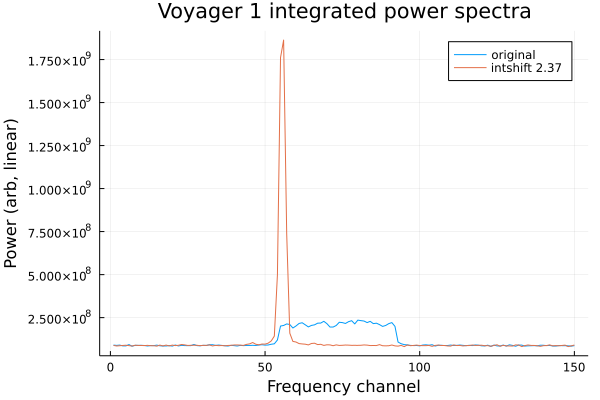

In [9]:
sum_orig = sum(spectrogram, dims=2)
sum_intshift = sum(intshift_m237, dims=2)
plot([sum_orig sum_intshift],
    title="Voyager 1 integrated power spectra",
    xlabel="Frequency channel",
    ylabel="Power (arb, linear)",
    labels=["original" "intshift 2.37"],
    legend=true
)

This shows that the original doppler drifting signal smears the power across
frequency whereas the `intshift`ed version, aka the *de-Doppler* version, keeps
all the power in much narrower range of frequencies.  The closer our shift rate
is to the actual opposite signed drift rate, the narrower the peak will be in
the integrated power spectrum, but ultimately the width of peak can be no
narrower than the inherent width of the signal itself.

In theory, because we have only rearranged the data, the total power in each
spectrum is still the same, but due to peculiarities of floating point math, the
sum of the power values in each integrated spectrum may not be identically
equal.  Julia provides an `isapprox` function and the `≈` operator that can be
used to check for "inexact equality".

In [10]:
sum(sum_orig) == sum(sum_intshift), sum(sum_orig) ≈ sum(sum_intshift)

(false, true)

Instead of searching drift rates one by one, we can loop over multiple drift
rates and store the integrated `intshift`ed power spectra for each drift rate as
columns in a `Matrix`.  The output matrix will be sized ($N_f$, $N_r$), where
$N_r$ is the number of drift rates used.  This resultant matrix is often called
a "frequency drift rate" matrix.

Here we create a function named `intfdr` that creates a frequency drift rate
matrix for a given spectrogram and range of rates using the `intshift` function.
This brute-force approach is not practical on full sized datasets, but for the
small spectrogram used as input for this notebook it is workable.

In [11]:
function intfdr(spectrogram, rates)
    Nf = size(spectrogram, 1)
    Nr = length(rates)
    fdr = similar(spectrogram, Nf, Nr)
    for (i,r) in enumerate(rates)
        fdr[:,i] .= sum(intshift(spectrogram, r), dims=2)
    end
    return fdr
end

intfdr (generic function with 1 method)

Let's try it out for drift rates from 0 to -5, stepping by -0.25 each time. 

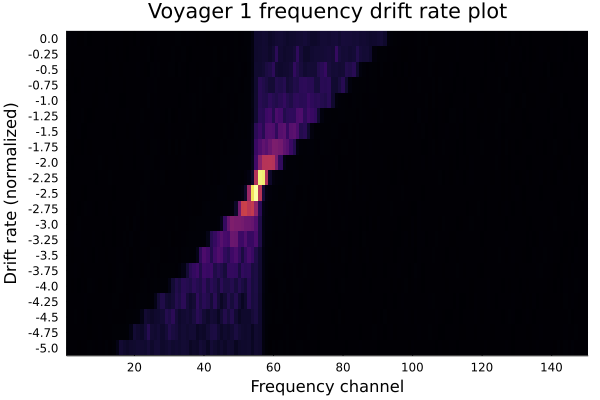

In [12]:
rates = 0:-0.25:-5
Nr = length(rates)
fdr = intfdr(spectrogram, rates)
heatmap(fdr',
    title = "Voyager 1 frequency drift rate plot",
    xlabel = "Frequency channel",
    ylabel = "Drift rate (normalized)",
    yflip=true, yticks=(1:Nr, rates)
)

This shows two adjacent peaks at drift rates of -2.25 and -2.5.  The actual peak
is probably somewhere between those two values so let's plot that range at a
somewhat higher resolution.

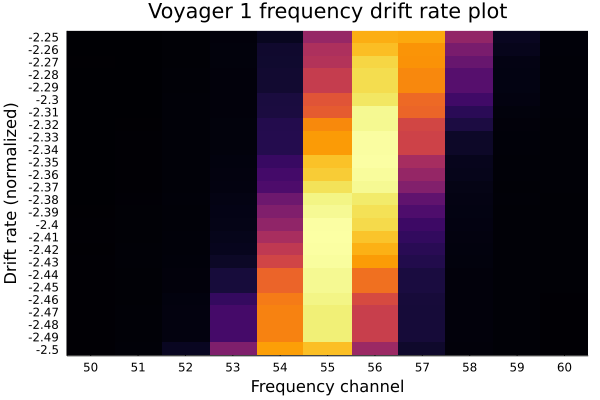

In [13]:
rates_zoom = -2.25:-0.01:-2.5
Nrz = length(rates_zoom)
fdr_zoom = intfdr(spectrogram, rates_zoom)
heatmap(50:60, 1:Nrz, fdr_zoom[50:60, :]',
    title="Voyager 1 frequency drift rate plot",
    xlabel="Frequency channel",
    ylabel="Drift rate (normalized)",
    xticks=50:60,
    yticks=(1:Nrz, rates_zoom),
    yflip=true
)

We definitely have higher resolution of the drift rates and we plotted just the channels around the peaks to get a really zoomed in view, but we still have double peaks as can be seen by plotting channels 55 and 56 over drift rate.

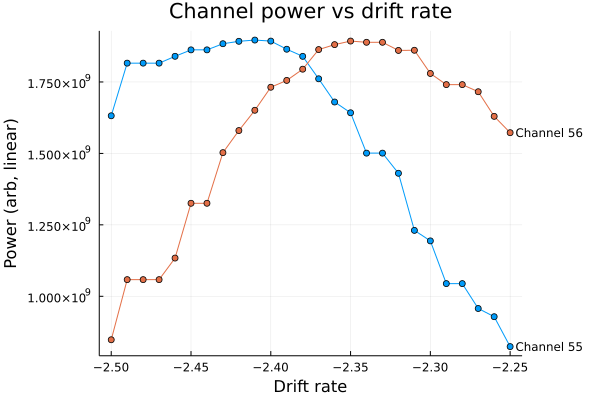

In [14]:
plot(rates_zoom, fdr_zoom[55:56, :]',
    title = "Channel power vs drift rate",
    xlabel = "Drift rate",
    ylabel = "Power (arb, linear)",
    labels = ["Channel 55" "Channel 56"],
    legend = :inline,
    marker = true
)

Part of this is inherent in the input freqeuncy resolution and the bandwidth of the signal itself, but part of this is due to the granular nature of shifting each spectrum by an integer number of samples.  A future notebooks will explore using Fourier domain shifting to effect shifts by non-integer values.


## Benchmarking

Let's benchmark the performance of our `intfdr` function using Julia's benchmarking tools.

In [17]:
using BenchmarkTools
@benchmark intfdr($spectrogram, $rates)

BenchmarkTools.Trial: 10000 samples with 1 evaluation.
 Range (min … max):  40.560 μs …   3.353 ms  ┊ GC (min … max):  0.00% … 96.41%
 Time  (median):     44.209 μs               ┊ GC (median):     0.00%
 Time  (mean ± σ):   54.826 μs ± 168.619 μs  ┊ GC (mean ± σ):  15.72% ±  5.03%

   ▃▅▇██▇▅▄▂▁▁▁▁▁▂▁                                ▁           ▂
  ▇█████████████████▇▅▄▃▃▄▆▆▅▆▄▅▅▅▃▃▄▃▄▄▃▄▄▁▁▄▃▆▆████▇█▇████▇▇ █
  40.6 μs       Histogram: log(frequency) by time      83.3 μs <

 Memory estimate: 227.36 KiB, allocs estimate: 127.

Wow, that's impressive, let's try with the full dataset!

In [18]:
full_spectrogram = h5["data"][:,1,:]
@benchmark intfdr($full_spectrogram, $rates)

BenchmarkTools.Trial: 10 samples with 1 evaluation.
 Range (min … max):  489.389 ms … 799.652 ms  ┊ GC (min … max):  7.65% … 43.33%
 Time  (median):     501.571 ms               ┊ GC (median):     9.50%
 Time  (mean ± σ):   548.641 ms ± 102.452 ms  ┊ GC (mean ± σ):  16.88% ± 12.06%

  ███ ▁ ▁                           ▁                         ▁  
  ███▁█▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁█ ▁
  489 ms           Histogram: frequency by time          800 ms <

 Memory estimate: 1.48 GiB, allocs estimate: 170.

What happened to our impressive performance???  Working with the small subset of
data gave overly optimistic performace results because most, if not all, of the
data involved still fit in the CPU's cache, which allows for very fast memory
access.  Working with a more realistic dataset shows a more realistic
performance measure.  In a future notebook we will run and benchmark this
implementation on a GPU.